In [26]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage.transform import resize
import numpy as np
import pickle

## Functions for predict and empty or not and get boxes of solts

In [27]:
EMPTY = True
NOT_EMPTY = False

MODEL = pickle.load(open("model.p", "rb"))

def Empty_or_not(spot_bgr):

    flat_data = []

    img_resized = resize(spot_bgr, (15, 15, 3))
    flat_data.append(img_resized.flatten())
    flat_data = np.array(flat_data)

    y_output = MODEL.predict(flat_data)

    if y_output == 0:
        return EMPTY
    else:
        return NOT_EMPTY


def get_parking_spots_bboxes(connected_components):
    (totalLabels, label_ids, values, centroid) = connected_components
    #print(values)

    slots = []
    coef = 1
    for i in range(1, totalLabels):

        # Now extract the coordinate points
        x1 = int(values[i, cv2.CC_STAT_LEFT] * coef)
        y1 = int(values[i, cv2.CC_STAT_TOP] * coef)
        w = int(values[i, cv2.CC_STAT_WIDTH] * coef)
        h = int(values[i, cv2.CC_STAT_HEIGHT] * coef)

        slots.append([x1, y1, w, h])

    return slots

C:\Users\youssef\Desktop\Praking_Avaliable\.venv\Lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator SVC from version 1.1.3 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [28]:
def calc_diff(im1, im2):
    return np.abs(np.mean(im1) - np.mean(im2))

mask_path = "mask_1920_1080.png"
video_path = "parking_1920_1080_loop.mp4"


mask = cv2.imread(mask_path, 0)

cap = cv2.VideoCapture(video_path)

connected_components = cv2.connectedComponentsWithStats(mask, 4, cv2.CV_32S)

spots = get_parking_spots_bboxes(connected_components)
print(spots)

[[533, 98, 65, 35], [991, 109, 64, 37], [611, 115, 63, 35], [1068, 127, 64, 35], [146, 137, 68, 27], [306, 136, 61, 26], [387, 136, 61, 26], [1674, 148, 71, 31], [1448, 150, 68, 33], [1518, 150, 68, 31], [1221, 152, 68, 33], [1291, 152, 69, 32], [534, 154, 64, 33], [387, 165, 61, 30], [837, 165, 69, 26], [992, 165, 64, 35], [307, 166, 62, 31], [763, 166, 72, 26], [147, 169, 68, 27], [613, 170, 61, 36], [1674, 181, 70, 29], [1069, 182, 64, 34], [1518, 183, 69, 30], [1448, 184, 68, 30], [1221, 187, 69, 29], [1292, 186, 68, 29], [1776, 186, 62, 26], [763, 193, 72, 28], [837, 193, 69, 27], [388, 199, 60, 30], [307, 200, 62, 29], [147, 203, 68, 27], [535, 208, 65, 36], [1675, 212, 69, 29], [1448, 215, 69, 29], [1519, 214, 68, 29], [1776, 214, 62, 29], [1292, 217, 68, 29], [992, 219, 71, 29], [1065, 219, 69, 29], [1221, 218, 69, 29], [837, 221, 69, 29], [764, 222, 71, 30], [613, 225, 62, 24], [309, 233, 68, 30], [381, 232, 68, 31], [148, 237, 68, 28], [1675, 243, 69, 30], [1448, 245, 69, 30]

[np.float64(1.0), np.float64(0.9649909977360659), np.float64(0.9434266261703109), np.float64(0.9240055249128234), np.float64(0.8482499064121066), np.float64(0.8433435834358359), np.float64(0.8049465580862698), np.float64(0.8020146753191686), np.float64(0.797939729397294), np.float64(0.7780786455207571), np.float64(0.772109471094712), np.float64(0.7566548828906595), np.float64(0.756457380166006), np.float64(0.740883064003056), np.float64(0.7374257981710259), np.float64(0.7344948563122), np.float64(0.7343111931119315), np.float64(0.7341109744430782), np.float64(0.7319557195571944), np.float64(0.7299261808210298), np.float64(0.7255091050181991), np.float64(0.7139504048713655), np.float64(0.7073230912219187), np.float64(0.6984237124979954), np.float64(0.6977464035509916), np.float64(0.6933487084870856), np.float64(0.6911833566611524), np.float64(0.6898126459525479), np.float64(0.687002255329899), np.float64(0.6848803919073682), np.float64(0.6831956254345158), np.float64(0.680448319428846),

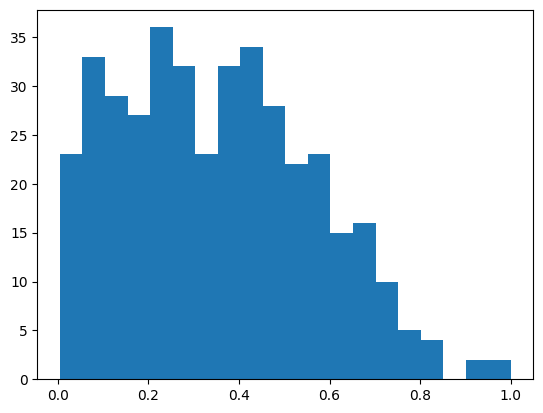

[np.float64(1.0), np.float64(0.6340617459841491), np.float64(0.5921536518254861), np.float64(0.5311235721512214), np.float64(0.49901891047711533), np.float64(0.47700800295818774), np.float64(0.4708451088631226), np.float64(0.46970012260186167), np.float64(0.46613080740037915), np.float64(0.4600284171743207), np.float64(0.4415418872006642), np.float64(0.4301836826231768), np.float64(0.4290834740700127), np.float64(0.4290394355396188), np.float64(0.42757234172420827), np.float64(0.42693721415354685), np.float64(0.42063771970846964), np.float64(0.4189807053632265), np.float64(0.39832079262068554), np.float64(0.388311831154775), np.float64(0.3869683974208966), np.float64(0.384169959153996), np.float64(0.37594504034266857), np.float64(0.37096794567772584), np.float64(0.3703102887160788), np.float64(0.36925433976899413), np.float64(0.3663781590095582), np.float64(0.35773877673825216), np.float64(0.3572328437645284), np.float64(0.3478373154178141), np.float64(0.34756982584904267), np.float64(

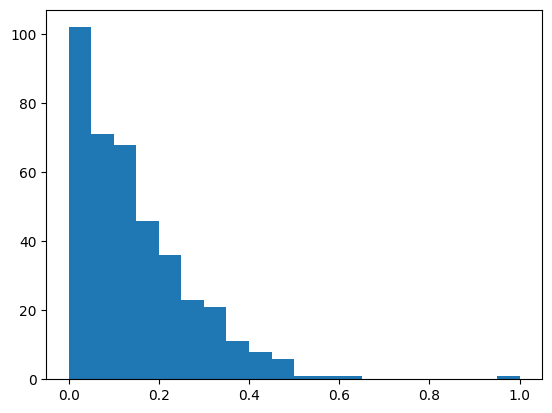

[np.float64(1.0), np.float64(0.8183646638441132), np.float64(0.7231703130052997), np.float64(0.7164311034235641), np.float64(0.6740755529749421), np.float64(0.6528284510496587), np.float64(0.5761048152673061), np.float64(0.5633961045344122), np.float64(0.5576647437610219), np.float64(0.5394887901010232), np.float64(0.5375886060050041), np.float64(0.5319170469110993), np.float64(0.5065259892744397), np.float64(0.5004491143792118), np.float64(0.49710129698740385), np.float64(0.49410711925075446), np.float64(0.4728466349360362), np.float64(0.4699719015619164), np.float64(0.4646144772361283), np.float64(0.46137534931401036), np.float64(0.45865153533525355), np.float64(0.4537466160945191), np.float64(0.44909816791201573), np.float64(0.4439376985346185), np.float64(0.4436865416696937), np.float64(0.43797426952502466), np.float64(0.43537619961456414), np.float64(0.4337461908974755), np.float64(0.4306216736178401), np.float64(0.4238570171923184), np.float64(0.4185018534197086), np.float64(0.41

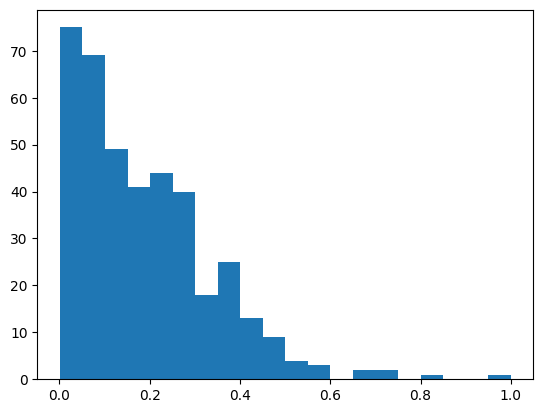

[np.float64(1.0), np.float64(0.5895611120746949), np.float64(0.49728068254847174), np.float64(0.4543530428247048), np.float64(0.4177766291598743), np.float64(0.4023011356235926), np.float64(0.3955166693790616), np.float64(0.3953233580286182), np.float64(0.3874607035342287), np.float64(0.3858054493715098), np.float64(0.38428636377892395), np.float64(0.37652757256217395), np.float64(0.37023961479559914), np.float64(0.3668668826494864), np.float64(0.35237970113928024), np.float64(0.3484076948179843), np.float64(0.34522910193857725), np.float64(0.3407419188103839), np.float64(0.3349794229361405), np.float64(0.3336451026740326), np.float64(0.3315971531947046), np.float64(0.3176670055720583), np.float64(0.31726138101025003), np.float64(0.31372652038828247), np.float64(0.31290823515918886), np.float64(0.3108608619323893), np.float64(0.3105308453072465), np.float64(0.31025022656259665), np.float64(0.301958777678474), np.float64(0.29809237917265335), np.float64(0.2937592365311028), np.float64(0

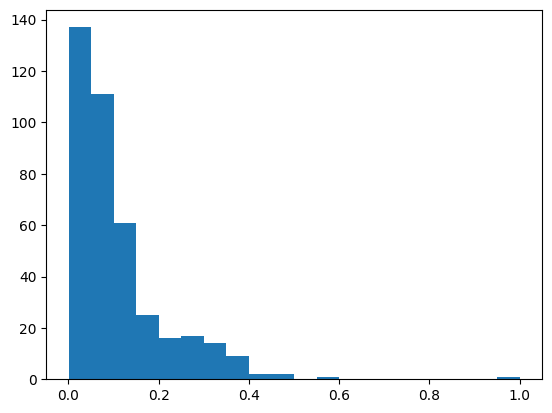

[np.float64(1.0), np.float64(0.7143086987570175), np.float64(0.3045100551723219), np.float64(0.2999513395693302), np.float64(0.2912017059277221), np.float64(0.2784017460784655), np.float64(0.2553029382970828), np.float64(0.2544900343433341), np.float64(0.2496201273431149), np.float64(0.2494451059547144), np.float64(0.23968681832231478), np.float64(0.23676547653579452), np.float64(0.23215751886105554), np.float64(0.22690959674227135), np.float64(0.2255224839793977), np.float64(0.22290878443630036), np.float64(0.2224814335142506), np.float64(0.2221534204401811), np.float64(0.21198190345179677), np.float64(0.20950160696014947), np.float64(0.20811797807136148), np.float64(0.2077209120322318), np.float64(0.20645423906998936), np.float64(0.20513050627170615), np.float64(0.2045696025436179), np.float64(0.20311071865656555), np.float64(0.20035481167256688), np.float64(0.1995342896474805), np.float64(0.19574564178830547), np.float64(0.1908103669966377), np.float64(0.19050717372974152), np.float

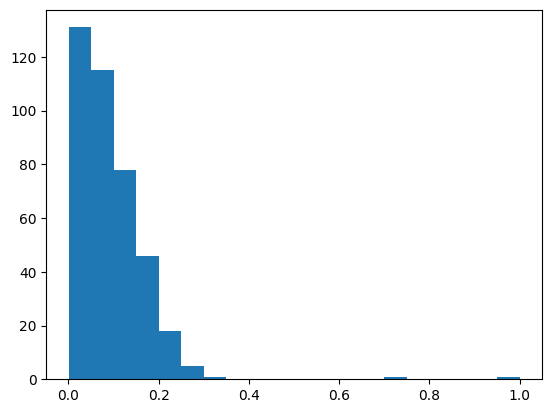

[np.float64(1.0), np.float64(0.42097862149275983), np.float64(0.23160104464704676), np.float64(0.2244919281790732), np.float64(0.2044251093094284), np.float64(0.19801912518279294), np.float64(0.18187050872867339), np.float64(0.18176379022730615), np.float64(0.17033432936278536), np.float64(0.16444144755310497), np.float64(0.1639029351111612), np.float64(0.1524632186576282), np.float64(0.1523825787323865), np.float64(0.14991250284392305), np.float64(0.14730463520464399), np.float64(0.14567810720134586), np.float64(0.13831840824128783), np.float64(0.13688838907137552), np.float64(0.13438195542002213), np.float64(0.1337281560261328), np.float64(0.1320344375963095), np.float64(0.13165523794784992), np.float64(0.13141619816945393), np.float64(0.1310309185266308), np.float64(0.13064399182651076), np.float64(0.13040474394373222), np.float64(0.12985483770015538), np.float64(0.12761189110803517), np.float64(0.1246537937719333), np.float64(0.12455284453218632), np.float64(0.12428816541927115), n

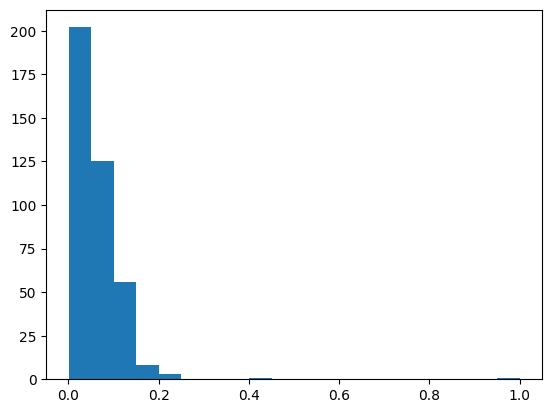

[np.float64(1.0), np.float64(0.6333584657353967), np.float64(0.23920504369721346), np.float64(0.21517860661062274), np.float64(0.19829117020851655), np.float64(0.1973218537716537), np.float64(0.19463054389781925), np.float64(0.1914083741163672), np.float64(0.19106922884397917), np.float64(0.18744671011033645), np.float64(0.18729763526533266), np.float64(0.18678508731964105), np.float64(0.18614337003685866), np.float64(0.1838696689478768), np.float64(0.17932045031171784), np.float64(0.17923234044527614), np.float64(0.17515245242980138), np.float64(0.17374673185430206), np.float64(0.1729986611283986), np.float64(0.1728810329329456), np.float64(0.16753726764365762), np.float64(0.16751485120400086), np.float64(0.16697383571755697), np.float64(0.16696314879360377), np.float64(0.16630469479798465), np.float64(0.16510460627970638), np.float64(0.16479647051478927), np.float64(0.16462271244775145), np.float64(0.16407998762310838), np.float64(0.16356842758381404), np.float64(0.16319968657013836)

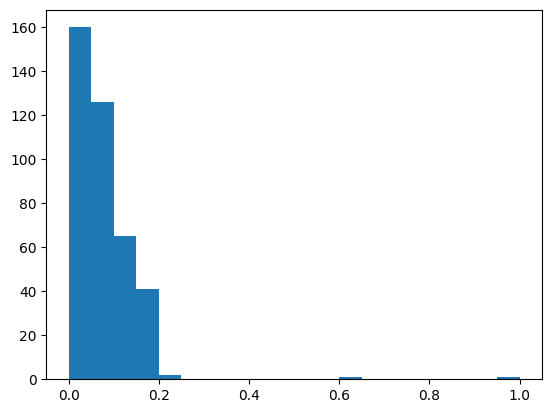

[np.float64(1.0), np.float64(0.8009218629142602), np.float64(0.6545553109484779), np.float64(0.53910594533161), np.float64(0.45851888121506845), np.float64(0.42072416916231825), np.float64(0.37302697005499375), np.float64(0.369997663154496), np.float64(0.3599485436076486), np.float64(0.3501605371659518), np.float64(0.3479765311145085), np.float64(0.3475635152019997), np.float64(0.3421047910918385), np.float64(0.33204555573108824), np.float64(0.33201410308774987), np.float64(0.3182666236007106), np.float64(0.3179989379705034), np.float64(0.3019062254438311), np.float64(0.30095798771644194), np.float64(0.30010270047935644), np.float64(0.2952142956307867), np.float64(0.2913435886328854), np.float64(0.28524463515630866), np.float64(0.2750902970756712), np.float64(0.27211238514564506), np.float64(0.2690545605997489), np.float64(0.2680809889575366), np.float64(0.2673676088327054), np.float64(0.2646813827571821), np.float64(0.26174438811414746), np.float64(0.2608436960790158), np.float64(0.26

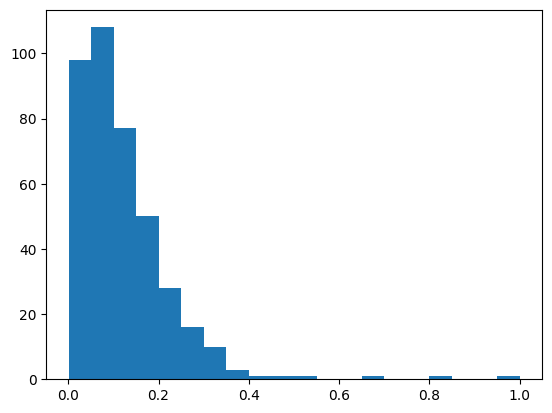

[np.float64(1.0), np.float64(0.8729364694969861), np.float64(0.7625353561326802), np.float64(0.6124015504318948), np.float64(0.5453359717672661), np.float64(0.4973310274909691), np.float64(0.396172287349167), np.float64(0.3820462272506501), np.float64(0.35261849661437983), np.float64(0.34089311733950367), np.float64(0.2990975965213964), np.float64(0.24458652458101074), np.float64(0.2350041230349082), np.float64(0.23074808700047056), np.float64(0.2280680179324059), np.float64(0.22730779120596756), np.float64(0.2239772741187014), np.float64(0.22358375967583238), np.float64(0.22252849918573694), np.float64(0.22231201557506536), np.float64(0.22188134526205733), np.float64(0.22132209801501876), np.float64(0.22115357484905884), np.float64(0.22062226793520398), np.float64(0.220585534290857), np.float64(0.21831614406219285), np.float64(0.2159176404483688), np.float64(0.20945524005436572), np.float64(0.20837452559030695), np.float64(0.20675307172145965), np.float64(0.20512163352709842), np.floa

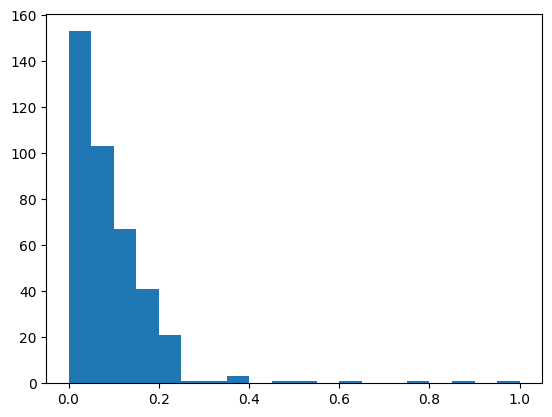

[np.float64(1.0), np.float64(0.636387812667787), np.float64(0.5903765386411295), np.float64(0.5659491216779846), np.float64(0.5220911113981153), np.float64(0.4741124298209262), np.float64(0.47139929551734133), np.float64(0.45450845051834676), np.float64(0.4375827223423279), np.float64(0.4340334005583337), np.float64(0.4268071271744653), np.float64(0.3981590947475102), np.float64(0.3919553533286303), np.float64(0.3893610227875452), np.float64(0.38784187614151083), np.float64(0.38700688092138025), np.float64(0.38508364244444904), np.float64(0.3706981633400799), np.float64(0.3665747152320368), np.float64(0.3592095764162771), np.float64(0.35478241288071083), np.float64(0.34810811487048654), np.float64(0.3441883793175809), np.float64(0.34031188241402), np.float64(0.33647012047514446), np.float64(0.3345507515622365), np.float64(0.3328655731841801), np.float64(0.3324532267447328), np.float64(0.33051849349771956), np.float64(0.3293116013505551), np.float64(0.32534103399680403), np.float64(0.32

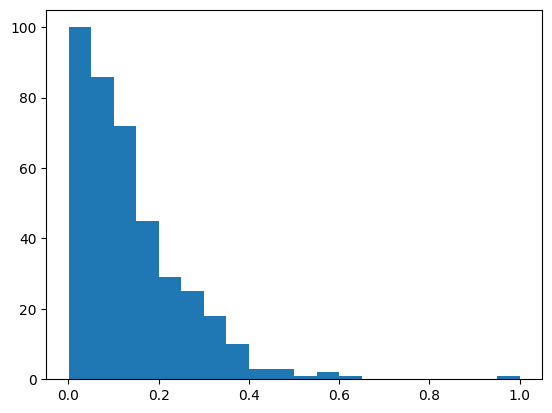

[np.float64(1.0), np.float64(0.9973288713725545), np.float64(0.8932161268534313), np.float64(0.8840151686799101), np.float64(0.8565136899542082), np.float64(0.8273725056061679), np.float64(0.8025327684983319), np.float64(0.7908422286956542), np.float64(0.7432957658038035), np.float64(0.7321150706125883), np.float64(0.7217685342481471), np.float64(0.701103826505762), np.float64(0.6960927604014424), np.float64(0.6909050590168272), np.float64(0.6672603287170621), np.float64(0.6493784886067898), np.float64(0.6482366227239952), np.float64(0.6454253142356049), np.float64(0.6437677375424496), np.float64(0.6261797484771232), np.float64(0.6093550487373265), np.float64(0.5998333776695385), np.float64(0.5887817077527643), np.float64(0.578678681705623), np.float64(0.573141107487789), np.float64(0.5703801973898466), np.float64(0.5603559712884474), np.float64(0.5554872373810135), np.float64(0.546430088083701), np.float64(0.5354368513882007), np.float64(0.5340427068684044), np.float64(0.5203666048952

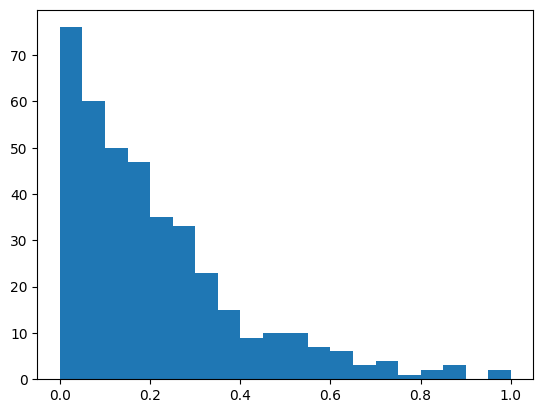

[np.float64(1.0), np.float64(0.6555361897694594), np.float64(0.5871109607577806), np.float64(0.5510866362564931), np.float64(0.5338714325100925), np.float64(0.4635124685868932), np.float64(0.4568158914667281), np.float64(0.45395390903316524), np.float64(0.44493846252980235), np.float64(0.42777651866121774), np.float64(0.4212237161441033), np.float64(0.4201838606439418), np.float64(0.41636273869353646), np.float64(0.40365425251804926), np.float64(0.3967289554522768), np.float64(0.3958310320068484), np.float64(0.395330195911131), np.float64(0.38245419617470683), np.float64(0.3767814184762768), np.float64(0.3721501286576872), np.float64(0.36997631935047315), np.float64(0.36359807793211973), np.float64(0.3596666451876154), np.float64(0.3551182684431764), np.float64(0.35465024748175533), np.float64(0.3506013366104204), np.float64(0.3504977769186164), np.float64(0.3464269882746619), np.float64(0.3428911390042458), np.float64(0.3389748181480621), np.float64(0.33889944853868875), np.float64(0.

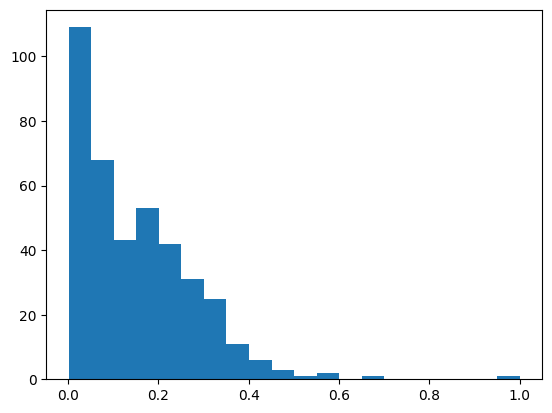

[np.float64(1.0), np.float64(0.5338503354465286), np.float64(0.4611041415887458), np.float64(0.44489935939152225), np.float64(0.3634425033628098), np.float64(0.3558109038413538), np.float64(0.31492720214051906), np.float64(0.29574992609084544), np.float64(0.2780696679860553), np.float64(0.24003297449326014), np.float64(0.23583098955807738), np.float64(0.23221381695923463), np.float64(0.22472701179121565), np.float64(0.21862820384405743), np.float64(0.21413051008059306), np.float64(0.20836028097593404), np.float64(0.20320590558015442), np.float64(0.2018035754695629), np.float64(0.19797525332384355), np.float64(0.19361902794117425), np.float64(0.19340177157081626), np.float64(0.18950536504747642), np.float64(0.18898573213635747), np.float64(0.18764389702475137), np.float64(0.17905993177400215), np.float64(0.17541503363056132), np.float64(0.17382863945779056), np.float64(0.1726938586763264), np.float64(0.17267253133432503), np.float64(0.17105627876273657), np.float64(0.16893049684232206),

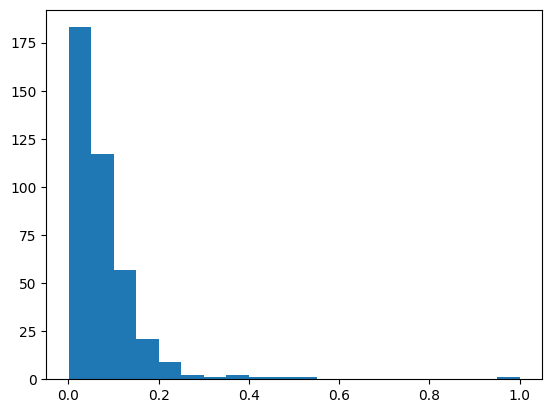

[np.float64(1.0), np.float64(0.9661557005772582), np.float64(0.6020142949967516), np.float64(0.560834397616007), np.float64(0.5436063947666633), np.float64(0.5384446190102119), np.float64(0.5354874219810202), np.float64(0.5198467530899701), np.float64(0.5188417467463666), np.float64(0.4750924061824265), np.float64(0.47093030482809256), np.float64(0.44595785999859894), np.float64(0.44524964649469695), np.float64(0.4287831499412347), np.float64(0.42400259909031796), np.float64(0.4214480341716416), np.float64(0.4194991523081847), np.float64(0.39778181084896397), np.float64(0.39248056283748983), np.float64(0.38496280461795807), np.float64(0.3769716179179424), np.float64(0.37136967578588953), np.float64(0.3676153346328773), np.float64(0.36757634827810454), np.float64(0.36299034801421187), np.float64(0.3625990903183912), np.float64(0.3603921236262968), np.float64(0.3599272729048344), np.float64(0.3524453108078846), np.float64(0.3507024763554975), np.float64(0.3424961723167007), np.float64(0.

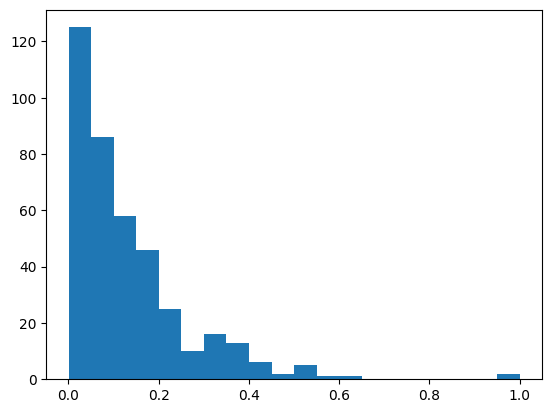

[np.float64(1.0), np.float64(0.9584158279711804), np.float64(0.9051926691729304), np.float64(0.7252142350826539), np.float64(0.7049548071430211), np.float64(0.6587813177725433), np.float64(0.6200343807362636), np.float64(0.6188713396951393), np.float64(0.5322243668132145), np.float64(0.5153584594207261), np.float64(0.509871421849641), np.float64(0.5035775151621843), np.float64(0.5025957877719303), np.float64(0.48683386224609804), np.float64(0.4848263667209474), np.float64(0.48195599170111486), np.float64(0.4692192633844951), np.float64(0.46838090798520376), np.float64(0.45254212494044854), np.float64(0.44484175692250966), np.float64(0.4417926710157751), np.float64(0.43753193180124333), np.float64(0.4369645320880239), np.float64(0.4318659281894552), np.float64(0.4309273206065131), np.float64(0.4270611819953959), np.float64(0.4262173139905337), np.float64(0.42121418357806684), np.float64(0.4090213455978279), np.float64(0.4076291379567941), np.float64(0.4076266292690957), np.float64(0.405

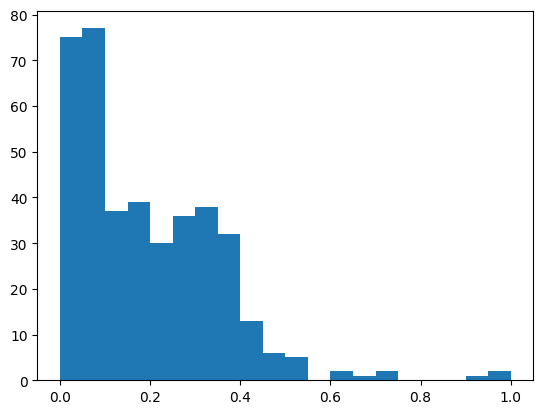

[np.float64(1.0), np.float64(0.7594505711435418), np.float64(0.55725209274536), np.float64(0.3586791327694986), np.float64(0.3550541875212009), np.float64(0.3189689133242749), np.float64(0.31393499930085333), np.float64(0.2862221992911985), np.float64(0.2840414262278871), np.float64(0.2746694933820088), np.float64(0.2743832851789666), np.float64(0.26078295590490647), np.float64(0.25792797492941055), np.float64(0.23038789228864692), np.float64(0.22594916959929714), np.float64(0.22403323682811993), np.float64(0.21874092827529712), np.float64(0.21562775381247917), np.float64(0.21333741732534595), np.float64(0.20468029004614297), np.float64(0.2020734703661527), np.float64(0.20100192405463876), np.float64(0.19891446720715097), np.float64(0.19874900162785072), np.float64(0.1953877434030177), np.float64(0.19508937433045634), np.float64(0.19309738265361007), np.float64(0.18983308025899892), np.float64(0.18810961075249366), np.float64(0.18500877205671237), np.float64(0.18286101670247956), np.fl

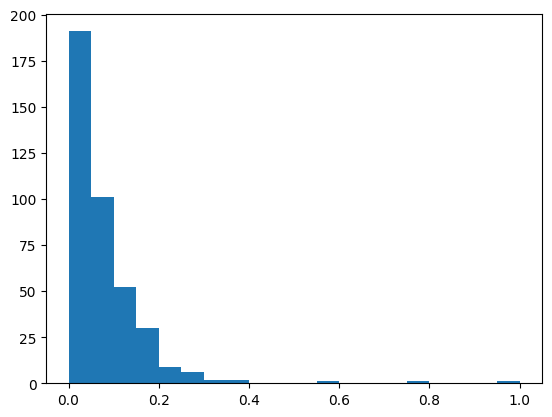

[np.float64(1.0), np.float64(0.8631524878583239), np.float64(0.4309974817378027), np.float64(0.3396235562799622), np.float64(0.33727571645552773), np.float64(0.27529701330367756), np.float64(0.2677880257673671), np.float64(0.2652712284385565), np.float64(0.2636197612929045), np.float64(0.24084213059391066), np.float64(0.23795235276201965), np.float64(0.23313086077947442), np.float64(0.2303276293032566), np.float64(0.2182712652242694), np.float64(0.20773207832117813), np.float64(0.20063788115202041), np.float64(0.1978394835301892), np.float64(0.19657854093634233), np.float64(0.19446901495540644), np.float64(0.1929909176540842), np.float64(0.19054868311141313), np.float64(0.18326234462679483), np.float64(0.1823209402607786), np.float64(0.18227934866020978), np.float64(0.1803494983937385), np.float64(0.17775377262990197), np.float64(0.1734037010984661), np.float64(0.17293665299011227), np.float64(0.1707520900249733), np.float64(0.17044963004209815), np.float64(0.16848455015962113), np.flo

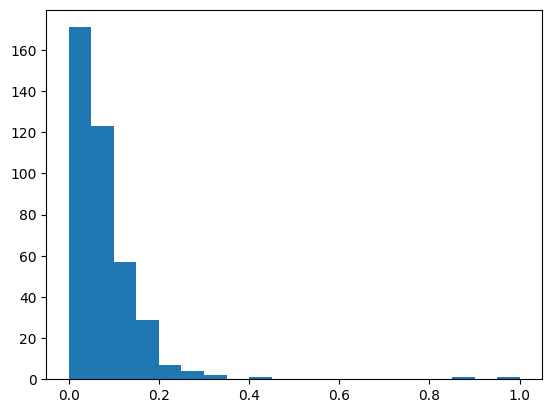

[np.float64(1.0), np.float64(0.8646669351320588), np.float64(0.8140313991329802), np.float64(0.7871399854434586), np.float64(0.7769577598481308), np.float64(0.7555852785088687), np.float64(0.7530256323927736), np.float64(0.7339192590355428), np.float64(0.6816671700392642), np.float64(0.6812259047382191), np.float64(0.6732389869266989), np.float64(0.6633645424343108), np.float64(0.6518971965107428), np.float64(0.6476260948354031), np.float64(0.6422228933856877), np.float64(0.6402295379039566), np.float64(0.6336472009522648), np.float64(0.6246536295441901), np.float64(0.6218121233157701), np.float64(0.6169032517869748), np.float64(0.6143158214660116), np.float64(0.5827127045321402), np.float64(0.5811723160560446), np.float64(0.5787531756888826), np.float64(0.5786083425618308), np.float64(0.5753622574416071), np.float64(0.5625332349693791), np.float64(0.5501078655563739), np.float64(0.5485438149889991), np.float64(0.5288726467331141), np.float64(0.5165775401069571), np.float64(0.509469161

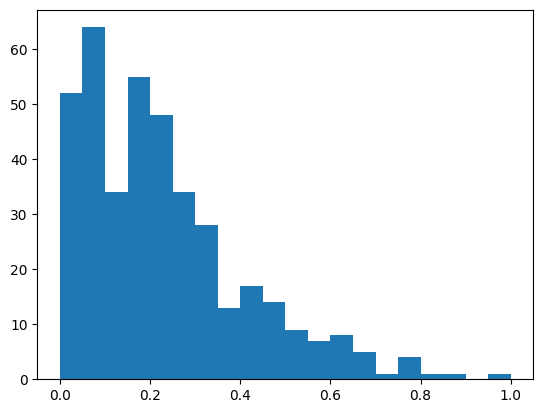

[np.float64(1.0), np.float64(0.8095187165775409), np.float64(0.5441788196810684), np.float64(0.43063780663780826), np.float64(0.40836890645586554), np.float64(0.384510035419126), np.float64(0.37704783971650585), np.float64(0.3750819672131127), np.float64(0.3740689655172435), np.float64(0.36960372960372767), np.float64(0.35777378076982147), np.float64(0.3494703557312242), np.float64(0.34167272727272546), np.float64(0.3411661442006257), np.float64(0.33301937406855703), np.float64(0.31308765264586175), np.float64(0.31222168206125317), np.float64(0.3086852295777244), np.float64(0.3073066064370407), np.float64(0.3056929955290609), np.float64(0.30513387121640556), np.float64(0.2959262187088277), np.float64(0.29487758143496), np.float64(0.29107136271436596), np.float64(0.2822771982116238), np.float64(0.2797742946708423), np.float64(0.26771241830065357), np.float64(0.26122793148880036), np.float64(0.253363188535602), np.float64(0.24761715515813823), np.float64(0.24602597402597326), np.float64(

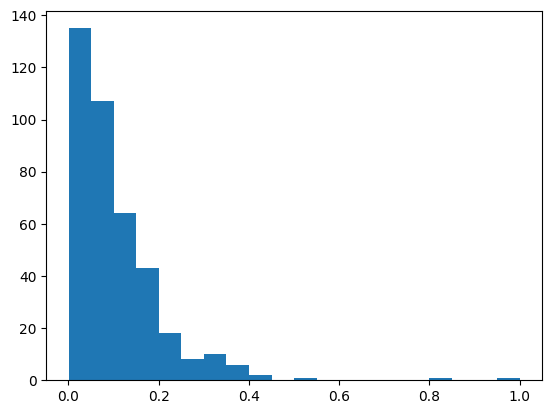

[np.float64(1.0), np.float64(0.6725612771812395), np.float64(0.43842131236600074), np.float64(0.4221963448164323), np.float64(0.3462425022326305), np.float64(0.3441342096363928), np.float64(0.3203040595180334), np.float64(0.3174354598537714), np.float64(0.315835871486866), np.float64(0.3034337938769166), np.float64(0.3029433958262061), np.float64(0.28411654728491614), np.float64(0.27789656845521965), np.float64(0.2770064749284742), np.float64(0.26903822139478906), np.float64(0.26113011027327265), np.float64(0.26046947414211347), np.float64(0.26034107858465116), np.float64(0.25623287337408573), np.float64(0.25598554434573406), np.float64(0.2517744018697361), np.float64(0.2497040271712779), np.float64(0.24792261802141302), np.float64(0.24708609628551478), np.float64(0.24594533398026847), np.float64(0.24360454416169192), np.float64(0.2368320179766708), np.float64(0.23568509683271677), np.float64(0.23466006605301437), np.float64(0.23381211221980866), np.float64(0.23144061157194362), np.flo

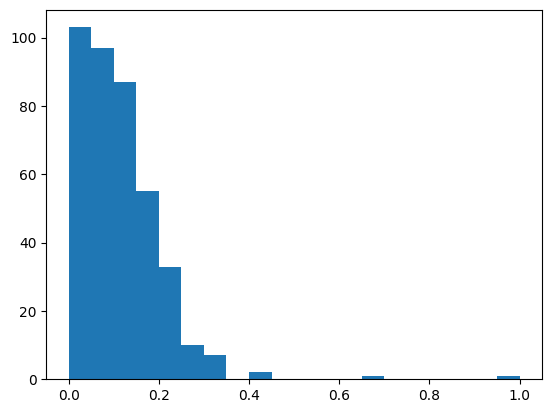

[np.float64(1.0), np.float64(0.7516467891239341), np.float64(0.5617857974999869), np.float64(0.43169202266629725), np.float64(0.43148922744899837), np.float64(0.4014629554778428), np.float64(0.37925224934580787), np.float64(0.37419707946825187), np.float64(0.36912416734959885), np.float64(0.3457546875477095), np.float64(0.3374783532526599), np.float64(0.3287570550767523), np.float64(0.3182630543151387), np.float64(0.31761309768817303), np.float64(0.3132438075778756), np.float64(0.2969381282047983), np.float64(0.295561124069284), np.float64(0.28546240251127525), np.float64(0.28132526624299686), np.float64(0.2770499018213836), np.float64(0.2741867250588033), np.float64(0.2652242609204043), np.float64(0.26004543499300875), np.float64(0.2598394304548082), np.float64(0.25077245249104907), np.float64(0.24701016570213732), np.float64(0.24462585891697425), np.float64(0.24316135147944862), np.float64(0.2321054585443409), np.float64(0.22664100679881513), np.float64(0.22250058305308718), np.float

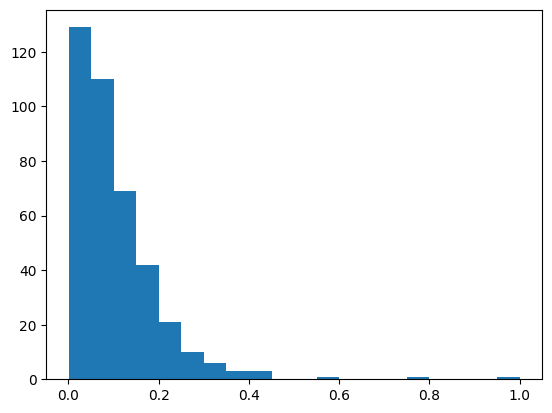

[np.float64(1.0), np.float64(0.9734052708702747), np.float64(0.9225231770037835), np.float64(0.9051336259743492), np.float64(0.76080934873717), np.float64(0.6048431002225607), np.float64(0.5701105396547596), np.float64(0.5190046301918442), np.float64(0.5116055505231076), np.float64(0.5102226478333737), np.float64(0.4925307941618817), np.float64(0.4879132853970444), np.float64(0.48779000492571545), np.float64(0.4784908972520195), np.float64(0.4503178783284114), np.float64(0.4436552133318075), np.float64(0.4401436437634669), np.float64(0.42838329830908817), np.float64(0.4073073597151191), np.float64(0.4067435340999478), np.float64(0.40508441628863134), np.float64(0.4012198162350434), np.float64(0.39660131629181994), np.float64(0.3958403712638825), np.float64(0.3937310253180793), np.float64(0.38990397068643157), np.float64(0.38364552142570485), np.float64(0.3740021298902889), np.float64(0.37344736776931065), np.float64(0.3706111244114551), np.float64(0.369240421685258), np.float64(0.36830

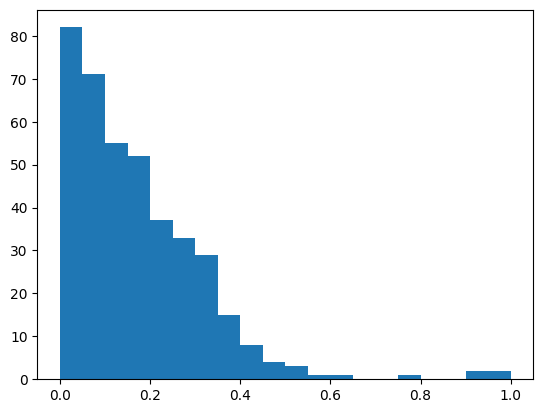

[np.float64(1.0), np.float64(0.9940312497517655), np.float64(0.5990604656718459), np.float64(0.5973494248038386), np.float64(0.5932734392997), np.float64(0.5898529657078879), np.float64(0.5650604782842392), np.float64(0.5578781402851846), np.float64(0.5548504930518672), np.float64(0.5511636380228064), np.float64(0.5466148750089357), np.float64(0.5219442524763912), np.float64(0.5166074875485528), np.float64(0.5154935215501412), np.float64(0.5084366408636978), np.float64(0.5078251475506227), np.float64(0.5056467885349211), np.float64(0.5038197377289743), np.float64(0.5026491591799103), np.float64(0.49979881747677163), np.float64(0.49653520164589193), np.float64(0.4813190282514051), np.float64(0.4809214466712734), np.float64(0.47730937571987925), np.float64(0.47051524226368757), np.float64(0.4678645473393213), np.float64(0.43638443390605924), np.float64(0.4351833758310915), np.float64(0.43331029716654895), np.float64(0.43233964680870535), np.float64(0.43159947784688707), np.float64(0.4281

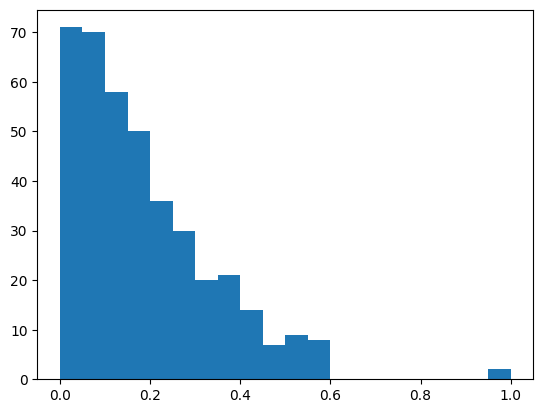

[np.float64(1.0), np.float64(0.9575920904196558), np.float64(0.8632989602472605), np.float64(0.8422965893909077), np.float64(0.7901067743071772), np.float64(0.7642571294928217), np.float64(0.7306955836749736), np.float64(0.7273307743137718), np.float64(0.7007597882984744), np.float64(0.6403080227985363), np.float64(0.6240892828208618), np.float64(0.6007370701737449), np.float64(0.5940158593798043), np.float64(0.5919180428784985), np.float64(0.591426461962565), np.float64(0.5784879015792164), np.float64(0.5738274884820024), np.float64(0.5514606229485945), np.float64(0.5441487795159611), np.float64(0.5367184657762017), np.float64(0.5274272268971048), np.float64(0.5247282519773564), np.float64(0.5213994455603198), np.float64(0.5095415121508245), np.float64(0.5017893337887064), np.float64(0.4980213383622764), np.float64(0.4771612090603079), np.float64(0.4759049467196035), np.float64(0.467662060926443), np.float64(0.462917727768824), np.float64(0.46288715579782125), np.float64(0.46130312007

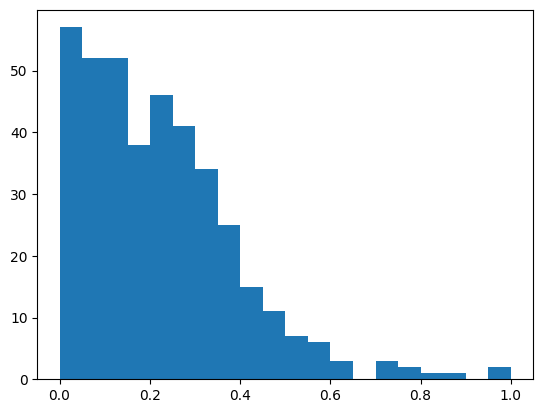

[np.float64(1.0), np.float64(0.5124773763353068), np.float64(0.30446719279803475), np.float64(0.2616672299577143), np.float64(0.2509360722199189), np.float64(0.22228005715452173), np.float64(0.21538734613097604), np.float64(0.20809056980864066), np.float64(0.20725059514046276), np.float64(0.20702728447982577), np.float64(0.20553611524217752), np.float64(0.19956677116560484), np.float64(0.19924474382526933), np.float64(0.19754262391385896), np.float64(0.19707801289756904), np.float64(0.1966790028133518), np.float64(0.1948886344743505), np.float64(0.1888939180134362), np.float64(0.18226168605837953), np.float64(0.182165321896292), np.float64(0.18173096550316686), np.float64(0.18061047444084877), np.float64(0.1779304264993444), np.float64(0.17787208865458995), np.float64(0.17136150234741754), np.float64(0.1682272171079861), np.float64(0.16795264339660973), np.float64(0.16652378036334048), np.float64(0.16596111007570302), np.float64(0.16586838259832665), np.float64(0.16567852664642088), np

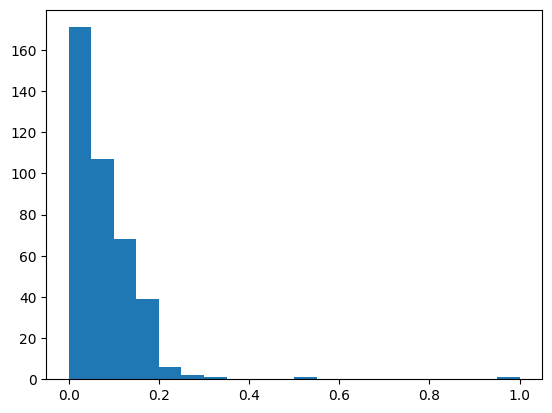

[np.float64(1.0), np.float64(0.3644710095957367), np.float64(0.3426273246680267), np.float64(0.2918859760753383), np.float64(0.27390789207076416), np.float64(0.2665900478841041), np.float64(0.2660418072969117), np.float64(0.2651819801476202), np.float64(0.261313680141351), np.float64(0.2537467058929548), np.float64(0.25329956731992975), np.float64(0.24943389847453473), np.float64(0.21871845955362895), np.float64(0.21494569358463783), np.float64(0.21216085517943448), np.float64(0.20929173997882622), np.float64(0.2068920052238708), np.float64(0.20633468198453417), np.float64(0.20556375668109086), np.float64(0.20342762957129867), np.float64(0.20247169873958293), np.float64(0.20056288984548057), np.float64(0.19663334532784554), np.float64(0.19663018579791464), np.float64(0.18920026906155493), np.float64(0.1857176355723936), np.float64(0.17771424935461577), np.float64(0.17749336436025087), np.float64(0.17449732756426645), np.float64(0.17195899632265826), np.float64(0.17117040637459432), np.

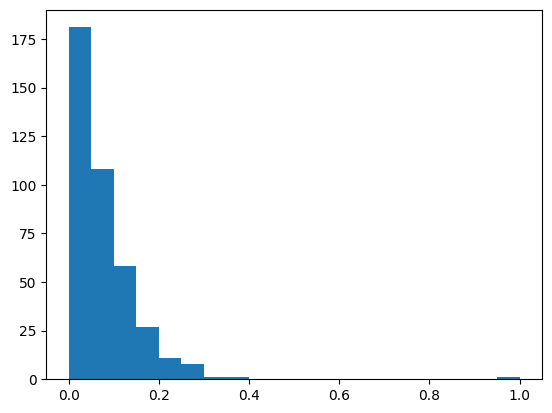

[np.float64(1.0), np.float64(0.7421031120453084), np.float64(0.5022479126525363), np.float64(0.4868268849168547), np.float64(0.3917307985693194), np.float64(0.36681847375489113), np.float64(0.3271995345694763), np.float64(0.32053744541287066), np.float64(0.3199606375027331), np.float64(0.3157858216918279), np.float64(0.3019630489537163), np.float64(0.28876895554617577), np.float64(0.27750706885128085), np.float64(0.27270994901052986), np.float64(0.26581510974574446), np.float64(0.25652507833960214), np.float64(0.25274185072805094), np.float64(0.2472543141052831), np.float64(0.24319683206966408), np.float64(0.236658995777989), np.float64(0.23452051879913224), np.float64(0.2297406350874565), np.float64(0.22255736556314645), np.float64(0.21839576608362607), np.float64(0.21839031749529608), np.float64(0.21746969394966), np.float64(0.2113269429394606), np.float64(0.21063733953907288), np.float64(0.20427306052701374), np.float64(0.20223331581713033), np.float64(0.20165075108268224), np.float

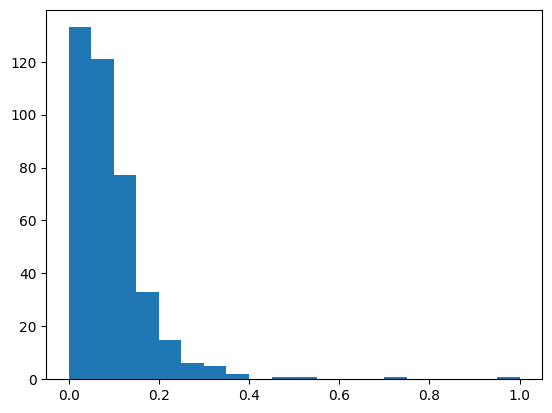

[np.float64(1.0), np.float64(0.4992289708003771), np.float64(0.4868925036064262), np.float64(0.31226358168475843), np.float64(0.30508649684892114), np.float64(0.2755745411132671), np.float64(0.2707460924067138), np.float64(0.2683850583289166), np.float64(0.2516490076108047), np.float64(0.249985650821346), np.float64(0.24805113198798634), np.float64(0.2448448461438099), np.float64(0.24329470841358788), np.float64(0.23333016781755983), np.float64(0.23264438143560673), np.float64(0.22457276062759401), np.float64(0.21570411630477804), np.float64(0.21299445785240173), np.float64(0.21046609958712695), np.float64(0.20940518399209673), np.float64(0.20768714198799387), np.float64(0.20298629758606462), np.float64(0.2005750740827574), np.float64(0.20038633336453976), np.float64(0.19933206057767844), np.float64(0.1890035432962518), np.float64(0.18778149672046124), np.float64(0.1860368129619711), np.float64(0.1858677809282186), np.float64(0.18340279702389936), np.float64(0.180711834054618), np.floa

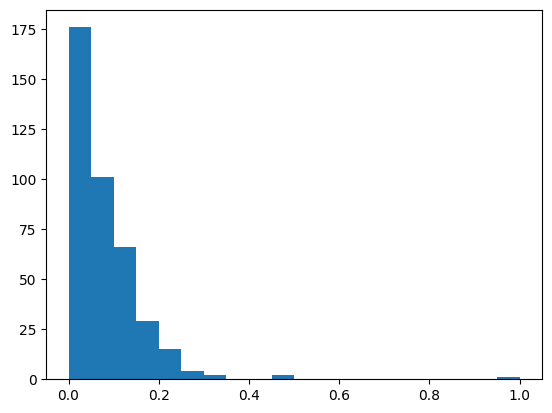

[np.float64(1.0), np.float64(0.7560446684964459), np.float64(0.7426527119112417), np.float64(0.5948768045716079), np.float64(0.5874374003458416), np.float64(0.5449072270440258), np.float64(0.5043348817694226), np.float64(0.5026804361844444), np.float64(0.4553398029813485), np.float64(0.4535117157000102), np.float64(0.44471874866762223), np.float64(0.4402100520243717), np.float64(0.43593041511251707), np.float64(0.43009232905411954), np.float64(0.42403826719665616), np.float64(0.4189055322249379), np.float64(0.4114397359024443), np.float64(0.4063217229221408), np.float64(0.3950143376815767), np.float64(0.3867142760897412), np.float64(0.38122041668185314), np.float64(0.3804173119646108), np.float64(0.3779099727651074), np.float64(0.37773136607604013), np.float64(0.3765777037757115), np.float64(0.373427989071688), np.float64(0.3544235043141022), np.float64(0.34998764849873354), np.float64(0.3499284629573257), np.float64(0.3489311584710108), np.float64(0.33915684365717913), np.float64(0.33

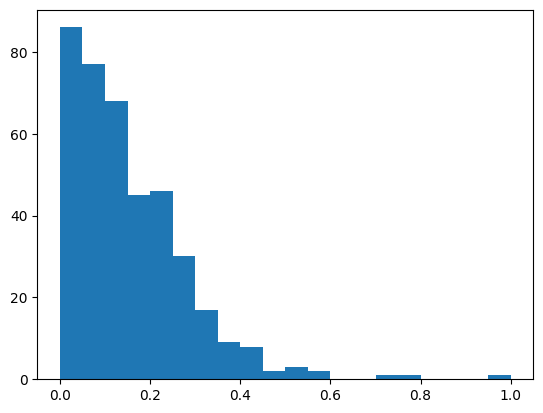

[np.float64(1.0), np.float64(0.4792823028269002), np.float64(0.4258053808847675), np.float64(0.30603444704835886), np.float64(0.2915917515902924), np.float64(0.2564126205535777), np.float64(0.25175993758270315), np.float64(0.23400763429161617), np.float64(0.2272322689086039), np.float64(0.22198951337555803), np.float64(0.21585745396315212), np.float64(0.2112771054942219), np.float64(0.20583400788864087), np.float64(0.20200491872671925), np.float64(0.19594491050404989), np.float64(0.19299821128916286), np.float64(0.18626183598163856), np.float64(0.16227734110963563), np.float64(0.1588764709643921), np.float64(0.15054675542606477), np.float64(0.14599752899739957), np.float64(0.14503715724058974), np.float64(0.14284030604513748), np.float64(0.138354984584196), np.float64(0.1372411027530285), np.float64(0.1370379053906318), np.float64(0.1366170709925894), np.float64(0.1363895163242061), np.float64(0.13504406033351327), np.float64(0.1302281975978946), np.float64(0.12829464534807325), np.flo

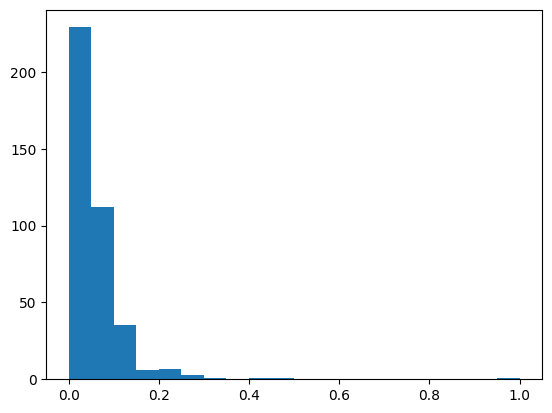

[np.float64(1.0), np.float64(0.36690356969794785), np.float64(0.3491725305171667), np.float64(0.26907386566938585), np.float64(0.26196356406408644), np.float64(0.2549950060270852), np.float64(0.23343024820976677), np.float64(0.23221974055776023), np.float64(0.22519771656143595), np.float64(0.2166226960282834), np.float64(0.213427207808256), np.float64(0.2034634973473273), np.float64(0.2002134936408373), np.float64(0.1992968816888251), np.float64(0.19614515868508303), np.float64(0.19206690468366266), np.float64(0.18790340817315554), np.float64(0.18664189953157925), np.float64(0.18284097466464133), np.float64(0.17850740498502599), np.float64(0.17330005186852068), np.float64(0.17295600301932804), np.float64(0.17044903892747396), np.float64(0.16793098276299515), np.float64(0.1666589750098062), np.float64(0.1660252090075123), np.float64(0.16089223888413523), np.float64(0.1597274129854793), np.float64(0.15556653913391827), np.float64(0.15252466374361323), np.float64(0.15212525804029378), np.

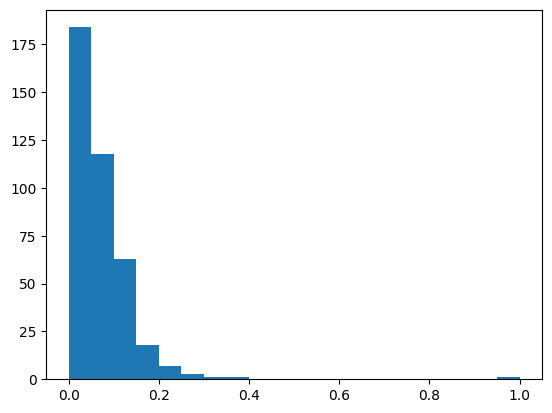

[np.float64(1.0), np.float64(0.8566180908855707), np.float64(0.7386177459687837), np.float64(0.7046075134373782), np.float64(0.6424436667885729), np.float64(0.6092546552454603), np.float64(0.59827315430644), np.float64(0.5546759262238402), np.float64(0.5070726687186702), np.float64(0.4895618070071629), np.float64(0.48931048832745), np.float64(0.48615496511466544), np.float64(0.4810518772690897), np.float64(0.47805466931102963), np.float64(0.4578360782961119), np.float64(0.41005216866430905), np.float64(0.39269026347393704), np.float64(0.387591493552179), np.float64(0.38174260287291706), np.float64(0.38111546968603865), np.float64(0.37561219693776954), np.float64(0.37489107723205317), np.float64(0.37020384860378147), np.float64(0.3699521513063743), np.float64(0.36336273632092253), np.float64(0.358998927223092), np.float64(0.3581710050381374), np.float64(0.3579977580408727), np.float64(0.3562128136587043), np.float64(0.35196243635287033), np.float64(0.3484521859101512), np.float64(0.3473

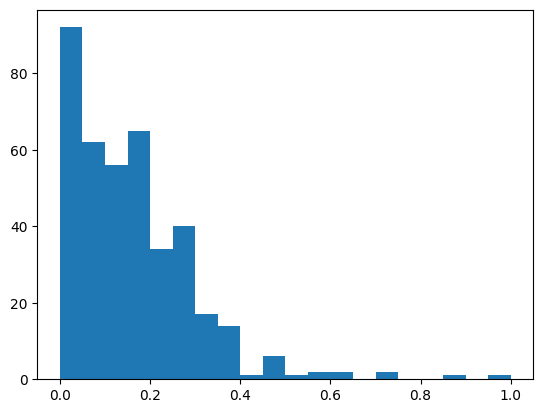

[np.float64(1.0), np.float64(0.3952649806017683), np.float64(0.38616130501092794), np.float64(0.33518725729256443), np.float64(0.3275765668161882), np.float64(0.32031982564180517), np.float64(0.31679659524701187), np.float64(0.30302022352315017), np.float64(0.3027332583021428), np.float64(0.3021332268937356), np.float64(0.2948028333206634), np.float64(0.29032913716795955), np.float64(0.2891660431980212), np.float64(0.2852802909348954), np.float64(0.2800482606153252), np.float64(0.2638741056117319), np.float64(0.26144225651942266), np.float64(0.25702099031477205), np.float64(0.24325175535347535), np.float64(0.2396363947388428), np.float64(0.23022121781637817), np.float64(0.22873425580983092), np.float64(0.22720033011700475), np.float64(0.22676609218042323), np.float64(0.22352844611429254), np.float64(0.2198159798778483), np.float64(0.21516320737981187), np.float64(0.21299481740540888), np.float64(0.210621820403212), np.float64(0.21011164220722975), np.float64(0.20972296138607974), np.fl

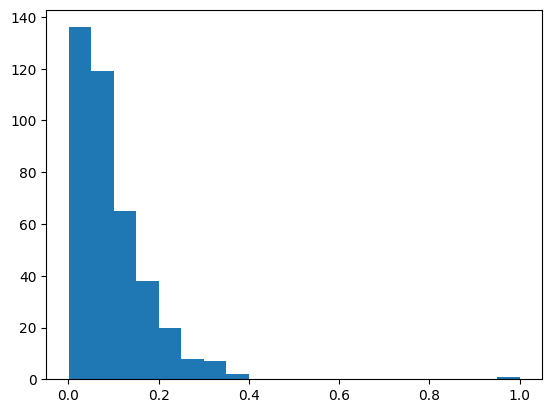

[np.float64(1.0), np.float64(0.8396186255675849), np.float64(0.6316218418907942), np.float64(0.5536787606240536), np.float64(0.5218113284433625), np.float64(0.5062571607431838), np.float64(0.46337213422628504), np.float64(0.4527855714546567), np.float64(0.4520171149144257), np.float64(0.45170516383442805), np.float64(0.4318120076066291), np.float64(0.4267394789399677), np.float64(0.4195318388679104), np.float64(0.40939535439199204), np.float64(0.3959179123617839), np.float64(0.39557864710676655), np.float64(0.3903547847685197), np.float64(0.3866193705542008), np.float64(0.37705901259225916), np.float64(0.3762377750611253), np.float64(0.3758895826056563), np.float64(0.36363250475414355), np.float64(0.36297241219107773), np.float64(0.3579041699531164), np.float64(0.35699159618956255), np.float64(0.35255365389839505), np.float64(0.35122918709077644), np.float64(0.3460994953514702), np.float64(0.33471771302345604), np.float64(0.33262930783560357), np.float64(0.3295639771801155), np.float64

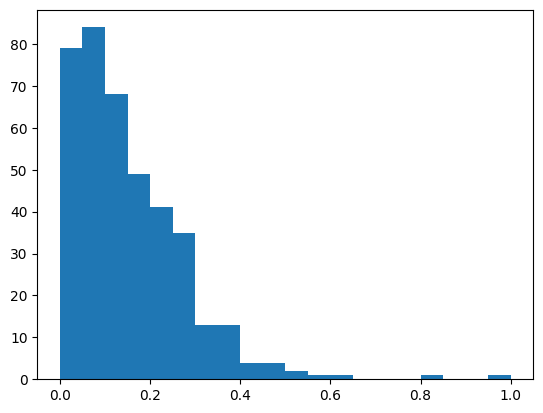

[np.float64(1.0), np.float64(0.447337437346521), np.float64(0.4368867808165415), np.float64(0.4147468741503969), np.float64(0.40855973937208157), np.float64(0.40415584286139755), np.float64(0.39995365231009694), np.float64(0.3985922132955787), np.float64(0.39447695445624376), np.float64(0.38508783842431066), np.float64(0.38334004189078696), np.float64(0.37549615116508467), np.float64(0.37510541328387226), np.float64(0.37110263786934417), np.float64(0.3683172037959219), np.float64(0.36695864736249667), np.float64(0.3577902985877848), np.float64(0.3564023138796193), np.float64(0.35607244314062564), np.float64(0.35408083962190023), np.float64(0.3483684040553407), np.float64(0.3422968167411583), np.float64(0.3388945147972987), np.float64(0.33483086895345326), np.float64(0.3333711756158115), np.float64(0.32836980776271985), np.float64(0.32293632172711595), np.float64(0.32151428574742896), np.float64(0.3203163459154799), np.float64(0.3150184228817157), np.float64(0.30958985671019734), np.flo

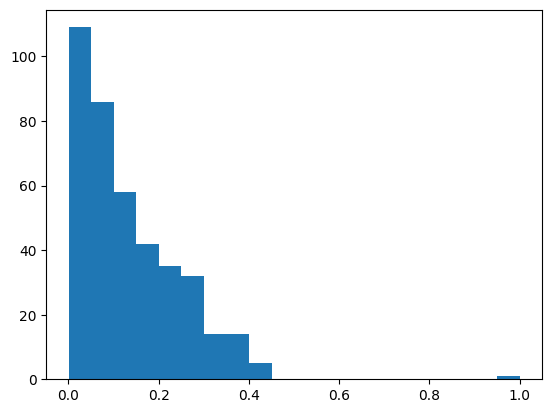

[np.float64(1.0), np.float64(0.9214469058274435), np.float64(0.8159831940898015), np.float64(0.7543860371809042), np.float64(0.6845310178385831), np.float64(0.6814280113556863), np.float64(0.6482182886295073), np.float64(0.6243670397244064), np.float64(0.6194662195840296), np.float64(0.5094399401661036), np.float64(0.5070559332685812), np.float64(0.4995135577453604), np.float64(0.467148488830482), np.float64(0.45889309731777544), np.float64(0.45478849393843385), np.float64(0.44282152363623806), np.float64(0.43525204879191154), np.float64(0.43293641969068725), np.float64(0.4250599056968418), np.float64(0.41951429016109015), np.float64(0.4184069749155701), np.float64(0.4114257661649558), np.float64(0.40977660972404145), np.float64(0.4080517521250159), np.float64(0.407764580259149), np.float64(0.39948770300634545), np.float64(0.3837337314019597), np.float64(0.38180121502980136), np.float64(0.3774320715527098), np.float64(0.3683156836979186), np.float64(0.3663329983767466), np.float64(0.36

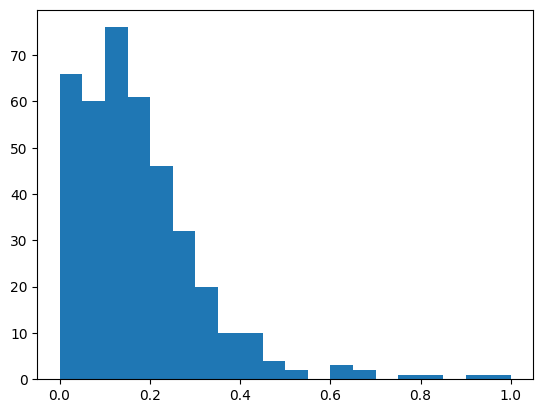

[np.float64(1.0), np.float64(0.8533497204328326), np.float64(0.4578517467101304), np.float64(0.45625682771258275), np.float64(0.4177506552781336), np.float64(0.3917162960613623), np.float64(0.38425728461490893), np.float64(0.3733366223819747), np.float64(0.36188401200605), np.float64(0.3614221701757364), np.float64(0.349596382694582), np.float64(0.3481741526953008), np.float64(0.3447580787257313), np.float64(0.3391916474366683), np.float64(0.3352618013860153), np.float64(0.3337562110159692), np.float64(0.32385498068454094), np.float64(0.32129912419834417), np.float64(0.32034347558222115), np.float64(0.3186695297565528), np.float64(0.31299317783442), np.float64(0.3128378616485184), np.float64(0.31178479900550776), np.float64(0.30440145188004303), np.float64(0.3007608152790117), np.float64(0.3003754492348922), np.float64(0.3003559220495473), np.float64(0.29645226017924386), np.float64(0.29210154411112715), np.float64(0.2832743687359195), np.float64(0.27963151313655044), np.float64(0.2790

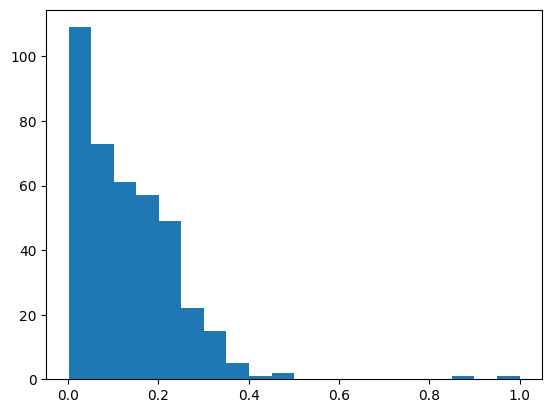

[np.float64(1.0), np.float64(0.6404033238638677), np.float64(0.5284601557819023), np.float64(0.49707354148636407), np.float64(0.4429465415085552), np.float64(0.42922301939677515), np.float64(0.4019113981167115), np.float64(0.3818998875040098), np.float64(0.37133637119885843), np.float64(0.3584550518163447), np.float64(0.35185145168348764), np.float64(0.34781608778014017), np.float64(0.3399085260285068), np.float64(0.3377205245988926), np.float64(0.3358214227403131), np.float64(0.3344563987229468), np.float64(0.3277411623726779), np.float64(0.321969243059719), np.float64(0.31945521147953837), np.float64(0.31657799299559786), np.float64(0.3138230133726753), np.float64(0.31000470309308636), np.float64(0.2983757522077765), np.float64(0.295681697796998), np.float64(0.29227317050247215), np.float64(0.2892390433503048), np.float64(0.2876472937886973), np.float64(0.28674338684462375), np.float64(0.28638846145131897), np.float64(0.2817307513978544), np.float64(0.28109979362226284), np.float64(0

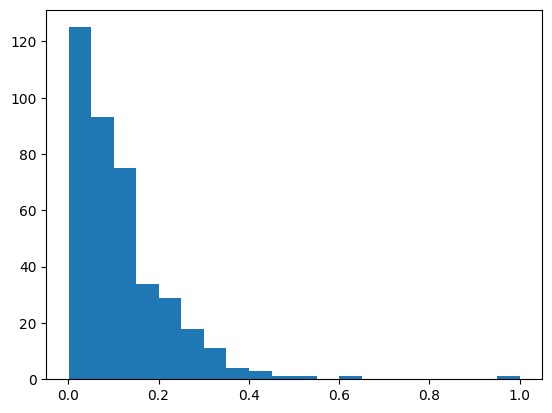

[np.float64(1.0), np.float64(0.7750221062870258), np.float64(0.7621935846001867), np.float64(0.6913157030430874), np.float64(0.6832228018981884), np.float64(0.6796670720693911), np.float64(0.670970023874786), np.float64(0.6031169864709508), np.float64(0.6013779585580804), np.float64(0.583856342889114), np.float64(0.5747067969463816), np.float64(0.5443282069420506), np.float64(0.541134598679862), np.float64(0.5353697341523901), np.float64(0.5346324894800046), np.float64(0.5335131311344927), np.float64(0.5255620448455517), np.float64(0.5232645115090373), np.float64(0.5218238199296792), np.float64(0.51448755989166), np.float64(0.5116725839685901), np.float64(0.5036293321820696), np.float64(0.4946502785392149), np.float64(0.4932354761694178), np.float64(0.4902072772447292), np.float64(0.48485277212838646), np.float64(0.48281301202061583), np.float64(0.47403016560766875), np.float64(0.4716870477963888), np.float64(0.4701163527573894), np.float64(0.465488296300037), np.float64(0.461091128761

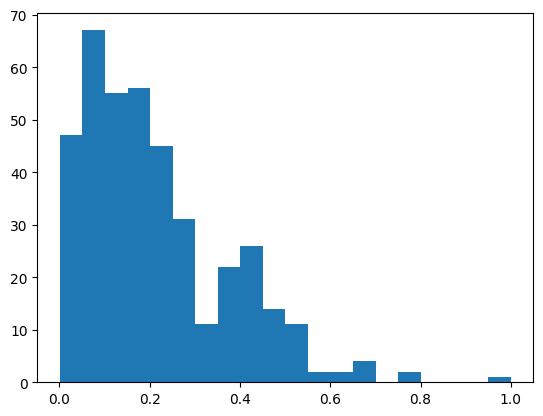

[np.float64(1.0), np.float64(0.894764151381054), np.float64(0.6326414425753208), np.float64(0.5485912717958857), np.float64(0.4893691465763527), np.float64(0.47965298571403947), np.float64(0.47842132124251235), np.float64(0.45669761599841985), np.float64(0.44727799877029484), np.float64(0.4399948431630117), np.float64(0.4105505454410578), np.float64(0.4102199785270767), np.float64(0.37449512363314047), np.float64(0.362990160058526), np.float64(0.3541353153587721), np.float64(0.3524598238726372), np.float64(0.33801871157289604), np.float64(0.33654169904622505), np.float64(0.33560179317515687), np.float64(0.32502868655138256), np.float64(0.32301739531395246), np.float64(0.32142515660584037), np.float64(0.31637786662771766), np.float64(0.3148903931585462), np.float64(0.31407926159953536), np.float64(0.31010840781806603), np.float64(0.30388197048102944), np.float64(0.30200863512682746), np.float64(0.2981667299961027), np.float64(0.2907836096844328), np.float64(0.2905283228710967), np.float

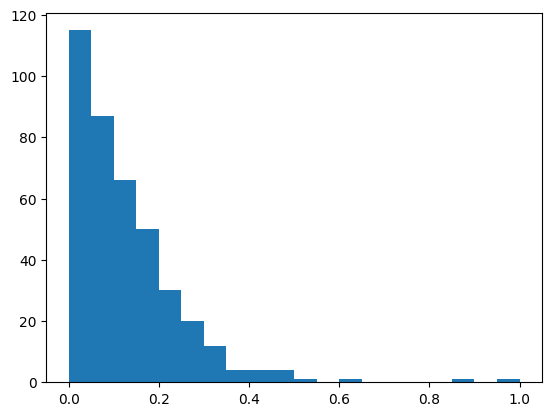

[np.float64(1.0), np.float64(0.7101734699038207), np.float64(0.40038076887787927), np.float64(0.3806751637421487), np.float64(0.3634888926668941), np.float64(0.3591774850753341), np.float64(0.35151948629034646), np.float64(0.35053223411983714), np.float64(0.34818992474766214), np.float64(0.32896195264144307), np.float64(0.30480083562880944), np.float64(0.2976732378482285), np.float64(0.29687877953774), np.float64(0.2784873229959941), np.float64(0.27052466059841085), np.float64(0.2683229959314801), np.float64(0.26089954286145933), np.float64(0.258142902367246), np.float64(0.24380677126341935), np.float64(0.24288530108741607), np.float64(0.232124111354727), np.float64(0.22556640754767218), np.float64(0.225557613916605), np.float64(0.22404196103618185), np.float64(0.21834315614492386), np.float64(0.2178628248559112), np.float64(0.2153775203523728), np.float64(0.2146540741442666), np.float64(0.21412155099676275), np.float64(0.2124812673945621), np.float64(0.2106099371426778), np.float64(0.

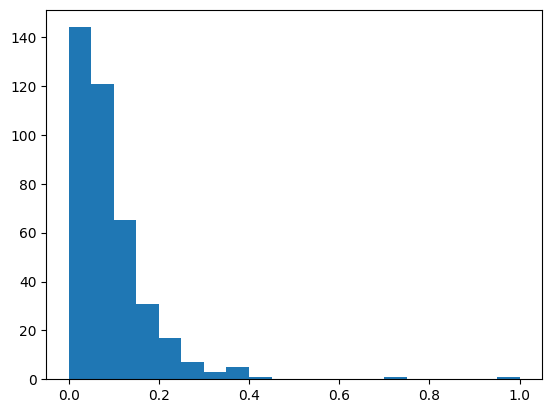

[np.float64(1.0), np.float64(0.7996669460936404), np.float64(0.47382230172928014), np.float64(0.3658469063711366), np.float64(0.33078045009827883), np.float64(0.29603561625193875), np.float64(0.27487253535542405), np.float64(0.2667291756626142), np.float64(0.24086468340731923), np.float64(0.23893171428054988), np.float64(0.22177380242496372), np.float64(0.21461374262183042), np.float64(0.2106645431364631), np.float64(0.208225163983304), np.float64(0.20415026833631628), np.float64(0.2008521117787655), np.float64(0.1949575003792082), np.float64(0.19441723954561896), np.float64(0.19396975117905424), np.float64(0.18935356650833926), np.float64(0.18912466247496515), np.float64(0.18909958258795484), np.float64(0.1880279657428294), np.float64(0.1863973685729115), np.float64(0.18473706497973438), np.float64(0.1827729145130921), np.float64(0.17852569243106536), np.float64(0.17820327760985252), np.float64(0.17688457279154932), np.float64(0.17187012933604737), np.float64(0.1708384019081709), np.f

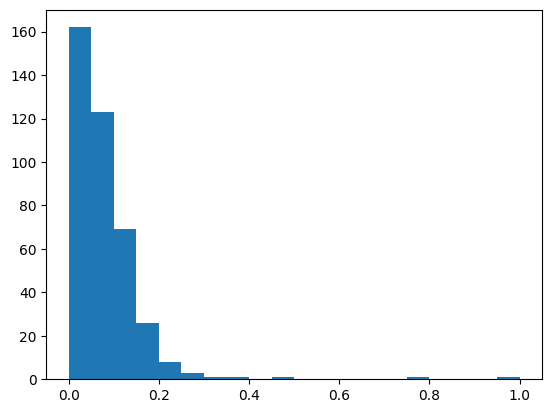

[np.float64(1.0), np.float64(0.6484210795002529), np.float64(0.47578406851136223), np.float64(0.4181161498940546), np.float64(0.41129700297678373), np.float64(0.3772808206815185), np.float64(0.35777717567341366), np.float64(0.3389950501073707), np.float64(0.33866373255922827), np.float64(0.3296853396714155), np.float64(0.322697697319732), np.float64(0.31831301675085594), np.float64(0.307975413036596), np.float64(0.28179928446704094), np.float64(0.27985923626159404), np.float64(0.2750350413287033), np.float64(0.2686108348927897), np.float64(0.2678979018624483), np.float64(0.26736184500956484), np.float64(0.2672906694281808), np.float64(0.26454422390133925), np.float64(0.2641494777345509), np.float64(0.2535432376902441), np.float64(0.25299559280717143), np.float64(0.2529204513531225), np.float64(0.2497296324654024), np.float64(0.24577902822588574), np.float64(0.24416299903236982), np.float64(0.23903259673462887), np.float64(0.23777243729969996), np.float64(0.23038935001896108), np.float6

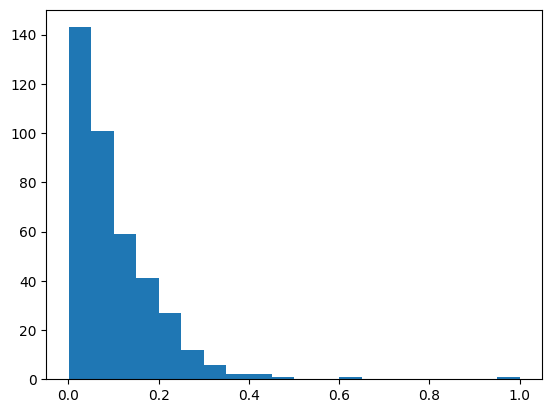

In [29]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Initialize spot status and differences lists
spots_status = [None for _ in spots]
diffs = [None for _ in spots]

previous_frame = None
frame_nmr = 0
ret = True
step = 30

# Start video capture loop
while ret:
    ret, frame = cap.read()

    if frame_nmr % step == 0 and previous_frame is not None:
        for spot_indx, spot in enumerate(spots):
            x1, y1, w, h = spot
            spot_crop = frame[y1:y1 + h, x1:x1 + w, :]
            diffs[spot_indx] = calc_diff(spot_crop, previous_frame[y1:y1 + h, x1:x1 + w, :])

        # Display histogram of differences
        sorted_diffs = [diffs[j] / np.amax(diffs) for j in np.argsort(diffs)][::-1]
        print(sorted_diffs)
        plt.hist(sorted_diffs, bins=20)
        plt.show()

    if frame_nmr % step == 0:
        if previous_frame is None:
            arr_ = range(len(spots))
        else:
            arr_ = [j for j in np.argsort(diffs) if diffs[j] / np.amax(diffs) > 0.4]

        for spot_indx in arr_:
            x1, y1, w, h = spots[spot_indx]
            spot_crop = frame[y1:y1 + h, x1:x1 + w, :]
            spot_status = Empty_or_not(spot_crop)
            spots_status[spot_indx] = spot_status

    if frame_nmr % step == 0:
        previous_frame = frame.copy()

    # Draw rectangles for each spot based on its status
    for spot_indx, spot in enumerate(spots):
        x1, y1, w, h = spot
        color = (0, 255, 0) if spots_status[spot_indx] else (0, 0, 255)
        frame = cv2.rectangle(frame, (x1, y1), (x1 + w, y1 + h), color, 2)

    # Display available spots
    cv2.rectangle(frame, (80, 20), (550, 80), (0, 0, 0), -1)
    cv2.putText(frame, f'Available spots: {sum(spots_status)} / {len(spots_status)}', 
                (100, 60), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    # Display the frame in a resized window
    cv2.namedWindow('frame', cv2.WINDOW_NORMAL)
    cv2.resizeWindow('frame', 640, 480)  # Adjusted window size
    cv2.imshow('frame', frame)

    if cv2.waitKey(25) & 0xFF == ord('q'):
        break

    frame_nmr += 1

cap.release()
cv2.destroyAllWindows()
